## Takeaway name classifier deep learning live demo


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode


## Build a Fastai Data Loader

Load in the dataframe and extract indexes for training, validation and balanced trainings.

In [22]:
df = pd.read_csv('07_07_2020_final.csv')
#df = pd.read_csv('07_07_2020_final_ff.csv')

valid_idx = df[df.valid].index
train_idx = df[~df.valid].index

bal_idx = []
for k, v in zip(df.index, df.bal):
    bal_idx += [k]*v



In [23]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [24]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [25]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [26]:
train_df = df.iloc[train_idx, [3,2]]
bal_df = df.iloc[bal_idx, [3,2]]
valid_df = df.iloc[valid_idx, [3,2]]

## Classifier with Just Eat data

In [27]:
data = TextClasDataBunch.from_df(path='.', train_df=bal_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab,
                         mark_fields=False, bs=128)

In [28]:
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.4, bptt=70)


In [29]:
learn.load('07_07_2020_final')
#learn.load('07_07_2020_final_ff')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (40038 items)
x: TextList
xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a
y: CategoryList
Fast Food,Fast Food,Fast Food,Fast Food,Fast Food
Path: .;

Valid: LabelList (4000 items)
x: TextList
xxbos   o m a r   s h a r i f s,xxbos   c h a r g h a s   f a s t   f o o d,xxbos   r o b e r t o ' s   p i z z a,xxbos   p o p   i n,xxbos   j a s m i n e   i n n
y: CategoryList
South Asian,Fast Food,Pizza,Fish & Chips,Southeast & East Asian
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(46, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropou

In [685]:
learn.predict("codfather")

(Category Fish & Chips,
 tensor(2),
 tensor([2.7391e-07, 2.1017e-02, 9.7697e-01, 4.4862e-06, 1.9881e-03, 1.6725e-05]))

In [686]:
learn.predict("corleones")

(Category Fast Food,
 tensor(1),
 tensor([2.3279e-04, 6.1608e-01, 3.1721e-01, 3.1279e-03, 5.9683e-02, 3.6587e-03]))

In [687]:
learn.predict("fire and dough")

(Category Fast Food,
 tensor(1),
 tensor([1.1598e-05, 5.8993e-01, 2.7940e-04, 3.4975e-01, 5.6722e-02, 3.3024e-03]))

In [688]:
learn.predict("sapna")

(Category Fast Food,
 tensor(1),
 tensor([0.0014, 0.4232, 0.0170, 0.0019, 0.3846, 0.1719]))

In [689]:
learn.predict("nam pla")

(Category Southeast & East Asian,
 tensor(5),
 tensor([5.1064e-05, 1.4828e-01, 1.3028e-02, 8.2811e-03, 1.5053e-01, 6.7983e-01]))

In [690]:
learn.predict("thaitanic")

(Category Southeast & East Asian,
 tensor(5),
 tensor([5.6692e-05, 5.0790e-04, 9.8033e-05, 1.1306e-04, 3.1584e-03, 9.9607e-01]))

In [691]:
    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`"
        x=torch.arange(0,data.c)
        cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        return cm.cpu().numpy()

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", figsize:tuple=None):
        "Plot the confusion matrix"
        # This function is copied from the scikit docs
        cm = self.confusion_matrix()
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, self.data.classes, rotation=45)
        plt.yticks(tick_marks, self.data.classes)

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [692]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [30]:
#txt_ci = TextClassificationInterpretation.from_learner(learn)
interp2 = TextClassificationInterpretation(learn, *learn.get_preds(with_loss=True, ordered=True))

In [694]:
#txt_ci.show_top_losses(20)
blah = interp2.show_top_losses(10000)


Text,Prediction,Actual,Loss,Probability
xxbos g e l a t o r i n o,Desserts,Sand/Caf/Bake,18.52,0.00
xxbos s w e e t s ' n ' t r e a t s,Desserts,Sand/Caf/Bake,17.79,0.00
xxbos d a i s y ' s d e l i,Sand/Caf/Bake,Desserts,15.21,0.00
xxbos t h e s n a c k s h a c k,Sand/Caf/Bake,Desserts,15.07,0.00
xxbos l u c a ' s,Sand/Caf/Bake,Fish & Chips,14.61,0.00
xxbos b l a c k m i l k n q,Fast Food,Desserts,14.52,0.00
xxbos b o n b o n,Southeast & East Asian,Desserts,14.01,0.00
xxbos j j ' s,Fast Food,Desserts,13.91,0.00
xxbos s p i r u l i n a,Fast Food,Sand/Caf/Bake,13.86,0.00
xxbos s u n f l o w e r s,Southeast & East Asian,Sand/Caf/Bake,13.84,0.00


In [695]:
my_top_losses = interp2.top_losses()
my_ds = interp2.data.dl('Valid').dataset
my_classes = interp2.data.valid_ds.classes
my_preds_class = interp2.pred_class
tl_val,tl_idx = my_top_losses


items = []
for idx in tl_idx:
    tx,cl = interp2.data.valid_ds[idx]
    cl = cl.data
    txt =  ' '.join([''.join(i.split()) for i in re.split(r' {2,}',tx.text)])[6:]
    tmp = [txt, f'{my_classes[my_preds_class[idx]]}', f'{my_classes[cl]}']
    items.append(tmp)
items = np.array(items)
names = ['Text', 'Prediction', 'Actual']
df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)

In [696]:
#df.to_csv('13_01_2020_errors.csv', index=False)

In [16]:
cm = interp2.confusion_matrix()

In [698]:
cm

array([[269,  71,   3,  30,  12,  15],
       [  7, 338,  10,  13,  23,   9],
       [  2,  44, 321,  11,   5,  17],
       [ 23,  83,  10, 243,  19,  22],
       [  1,  37,   3,  10, 329,  20],
       [  1,  32,   9,   4,  12, 342]])

In [18]:
classes = learn.data.classes

In [14]:
color_list = [(0.4,0.4,0.4), (0.7,0.7,0.7), (1.0,1.0,1.0)]

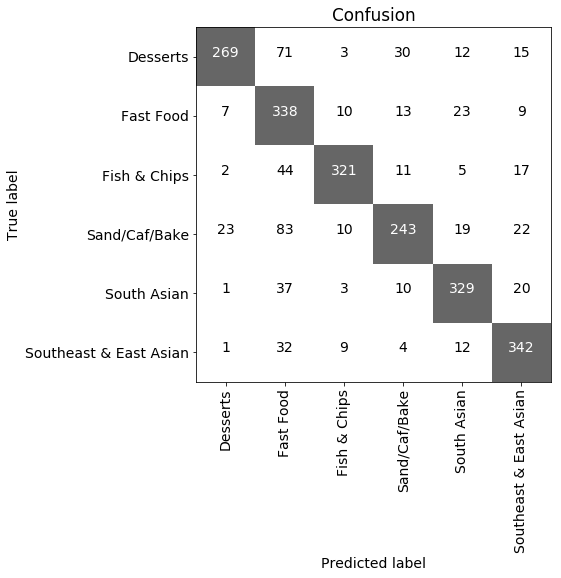

In [20]:
#import matplotlib.cm as cm
import matplotlib.colors as colors

# Discrete color map: make a color map of fixed colors
# [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#color_list = []
#for i in range(10):
#    i += 1
#    color_list.append((i*0.1, i*0.1, i*0.1))
# Reversed gray scale (black for 100, white for 0)
color_map = colors.ListedColormap(list(reversed(color_list)))
# Set color bounds: [0,10,20,30,40,50,60,70,80,90,100]
plt.figure(figsize=(8,8))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#cm = np.around(cm, decimals=3)
plt.imshow(cm, interpolation='nearest', cmap=color_map)
plt.title('Confusion')
#plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

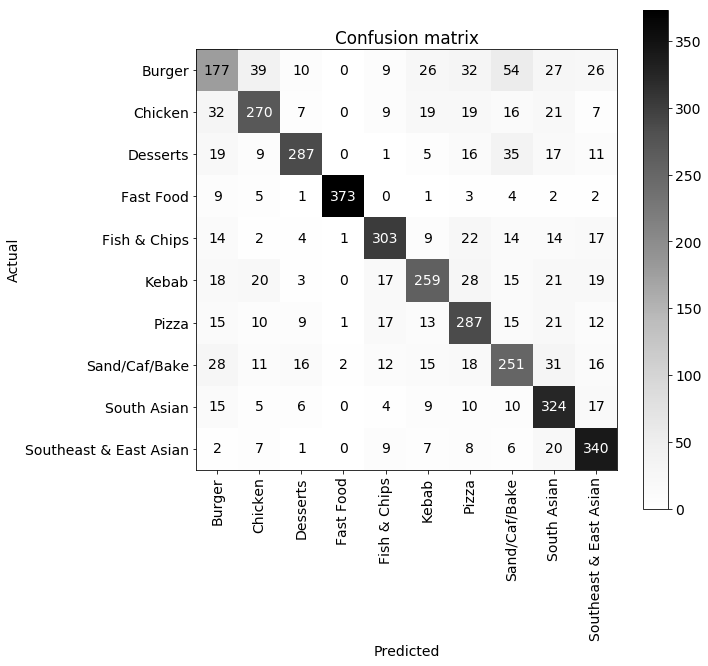

In [32]:
plt.rcParams.update({'font.size': 14})
interp2.plot_confusion_matrix(figsize=(10,10),cmap = 'Greys', )
plt.colorbar()

In [703]:
#Precision = tp / tp + fp
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [704]:
cats = bal_df.label_final.unique()
cats.sort()
data = [[cats],[recall],[precision]] 
  
data = {'Cuisine':cats, 'Recall (sensitivity)':recall, 'Precision (PPV)':precision} 
df = pd.DataFrame(data) 

In [705]:
df.loc['mean'] = df.mean()

In [706]:
df

,Cuisine,Recall (sensitivity),Precision (PPV)
0,Desserts,0.6725,0.887789
1,Fast Food,0.8450,0.558678
2,Fish & Chips,0.8025,0.901685
3,Sand/Caf/Bake,0.6075,0.781350
4,South Asian,0.8225,0.822500
5,Southeast & East Asian,0.8550,0.804706
mean,NaN,0.7675,0.792785


In [707]:
precision

array([0.887789, 0.558678, 0.901685, 0.78135 , 0.8225  , 0.804706])

In [708]:
precision.mean()

0.7927847037924636

In [709]:
recall.mean()

0.7675000000000001

In [710]:
np.sum(np.diag(cm)/np.sum(cm, axis = 0)*np.sum(cm, axis = 1))/np.sum(cm)

0.7927847037924636

In [711]:
np.sum(np.diag(cm))/np.sum(np.sum(cm, axis = 1))

0.7675